In [31]:
from torchvision.utils import make_grid
import os
import torch
import PIL.Image
import imageio
import numpy as np
from IPython.display import Video

from legacy import load_network

In [40]:
def generate_blended_img(G_s, G_t, z=None, blend_weights=[0,0.25,0.5,0.75,1], truncation_psi=0.7, truncation_cutoff=8):
    all_images = []
    
    if z == None:
        z = torch.randn([1,512]).cuda()
    assert z.shape == torch.Size([1, 512])
    
    c = torch.zeros(1,0).cuda()

    img = G_s(z, c, truncation_psi, truncation_cutoff, noise_mode='const')
    all_images.append(img)

    for weight in blend_weights:
        img = G_t(z, c, truncation_psi, truncation_cutoff, noise_mode='interpolate', blend_weight=weight)
        all_images.append(img)

    all_images = torch.cat(all_images)
    images = make_grid(all_images, nrow=len(blend_weights)+1, padding=5, pad_value=0.99999)
    images = (images.permute(1, 2, 0) * 127.5 + 128).clamp(0, 255).to(torch.uint8).cpu().numpy()
    images = PIL.Image.fromarray(images, 'RGB')
    return images

In [2]:
c_dim = 0
img_resolution = 256
img_channels = 3

## Download [pretrained weights](https://drive.google.com/drive/folders/1oJXMEHbZdU36CkRzgt_GxX2mgUgvHO_S?usp=sharing) and locate them to 'pretrained' directory.

### Metfaces

In [3]:
target_dataset = 'metfaces'
cfg = 'paper256'
source_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res256-mirror-paper256-noaug.pkl'
target_pkl = 'pretrained/metfaces-fm0.05-001612.pkl'

### AAHQ

In [ ]:
target_dataset = 'aahq'
cfg = 'paper256'
source_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res256-mirror-paper256-noaug.pkl'
target_pkl = 'pretrained/aahq-fm0.05-010886.pkl'

### Wikiart

In [ ]:
target_dataset = 'wikiart'
cfg = 'stylegan2'
source_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-church-config-f.pkl'
target_pkl = 'pretrained/wikiart-fm0.05-004032.pkl'

In [4]:
G_s = load_network(cfg, source_pkl, img_resolution, img_channels, c_dim).cuda()
G_t = load_network(cfg, target_pkl, img_resolution, img_channels, c_dim).cuda()

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res256-mirror-paper256-noaug.pkl"
Loading networks from "pretrained/metfaces-fm0.05-001612.pkl"


# Generate Noise Interpolation result images

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


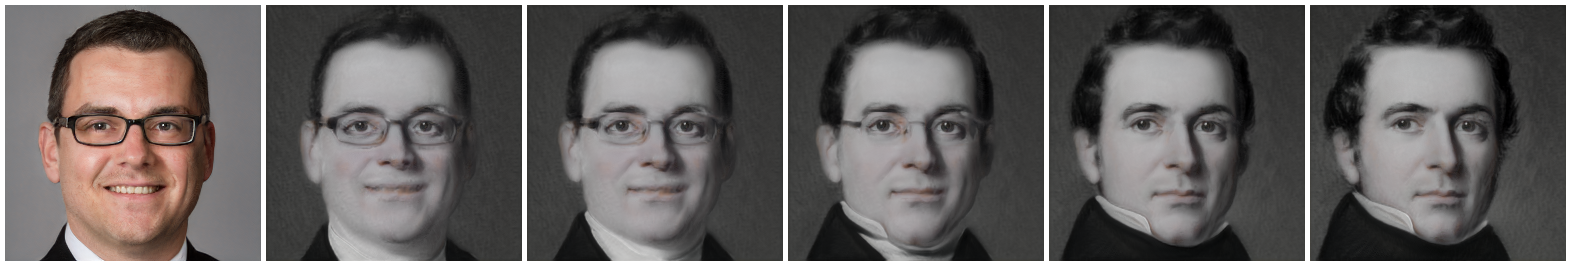

In [6]:
generate_blended_img(G_s, G_t)

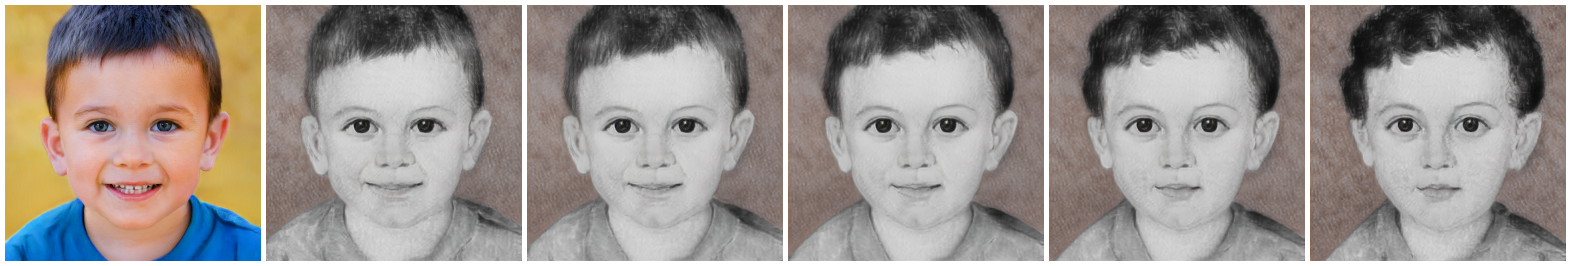

In [44]:
z = torch.randn([1,512]).cuda()
generate_blended_img(G_s, G_t, z=z)

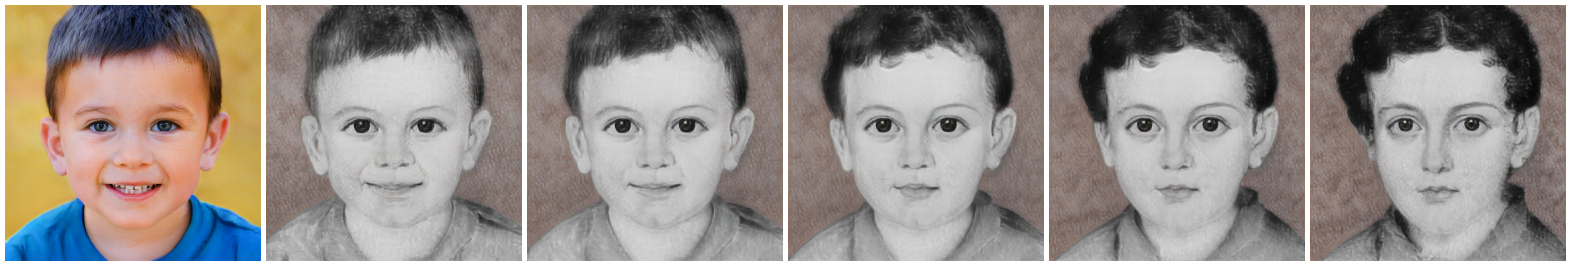

In [45]:
G_t.sample_noise()
generate_blended_img(G_s, G_t, z=z)

# Generate Noise Interpolation result video

In [36]:
num_step = 201
truncation_psi = 0.7 
truncation_cutoff = 8

blend_weights = np.linspace(0,1,num_step)

outdir = 'results'
os.makedirs(outdir, exist_ok=True)
video = imageio.get_writer(f'{outdir}/noise_interpolation_{target_dataset}00.mp4', mode='I', fps=50, codec='libx264', bitrate='16M')

z = torch.randn([1,512]).cuda()
c = torch.zeros(1,0).cuda()

img_source = G_s(z, c, truncation_psi, truncation_cutoff, noise_mode='const')

for weight in blend_weights:
    img = G_t(z, c, truncation_psi, truncation_cutoff, noise_mode='interpolate', blend_weight=weight)
   
    all_images = torch.cat([img_source, img])
    images = make_grid(all_images, nrow=2, padding=0)
    images = (images.permute(1, 2, 0) * 127.5 + 128).clamp(0, 255).to(torch.uint8).cpu().numpy()
    video.append_data(images)
video.close()

In [38]:
Video(f'{outdir}/noise_interpolation_{target_dataset}00.mp4')